# Automated Trading Algorithms


In [1]:
# Import libraries
% matplotlib inline

import datetime as dt
import numpy as np

from trading_session import * 
from financial_series.everything import * 
from financial_series.stationary_test import adf
from metallic_blue_lizard.neural_net import adaline

## Open a new 'trading session' and get available trading stocks

In [2]:
# Create instance of trading_session object

ts = TradingSession(user='sd8892',pw='Mexico0r',alias='Trading Session')

In [3]:
# Get exchange rate
er = ts.getExchangeRates()
er 

{'Buy': 20.282, 'Sell': 20.292}

In [4]:
# Print available stocks
available_stocks = ts.getOptions()
print(available_stocks)

# close session
ts.close()

['AC', 'ALFA.A', 'ALSEA', 'AMX.L', 'ASUR.B', 'BIMBO.A', 'CEMEX.CPO', 'ELEKTRA', 'FEMSA.UBD', 'GAP.B', 'GCARSO.A1', 'GENTERA', 'GFINBUR.O', 'GFNORTE.O', 'GFREGIO.O', 'GMEXICO.B', 'GRUMA.B', 'ICA', 'ICH.B', 'IENOVA', 'KIMBER.A', 'KOF.L', 'LAB.B', 'LACOMER.UBC', 'LALA.B', 'LIVEPOL.C1', 'MEXCHEM', 'NAFTRAC.ISHRS', 'NEMAK.A', 'OHLMEX', 'OMA.B', 'PENOLES', 'PINFRA', 'SANMEX.B', 'SIMEC.B', 'TLEVISA.CPO', 'WALMEX']


## Download prices 

In [5]:

# Create list of Stock instances.
obj = list(map(lambda x: 
               Stock(units='MXN',stock_name=yahoo_dict[x],t0='2016/01/01',tf='2017/02/02'), 
               available_stocks))

# Save information in stocks dictionary 
stocks = {}
total_errors = 0
for i,j in zip(obj,available_stocks):
    print('\n- Downloading data: {}'.format(i.name()),end=' ')
    try:
        i.fill()
    except:
        print('\n\t>> Error: cannot download data: {}\n'.format(i.name()))
        total_errors += 1
        continue
    stocks[j] = i
    print('Done.')

# print total of unavailable stock information 
del obj
print('\nTotal Errors: {}'.format(total_errors))


- Downloading data: AC.MX : (MXN) Done.

- Downloading data: ALFAA.MX : (MXN) Done.

- Downloading data: ALSEA.MX : (MXN) Done.

- Downloading data: AMXL.MX : (MXN) Done.

- Downloading data: ASURB.MX : (MXN) Done.

- Downloading data: BIMBOA.MX : (MXN) Done.

- Downloading data: CEMEXCPO.MX : (MXN) Done.

- Downloading data: ELEKTRA.MX : (MXN) Done.

- Downloading data: FEMSAUBD.MX : (MXN) 
	>> Error: cannot download data: FEMSAUBD.MX : (MXN)


- Downloading data: GAPB.MX : (MXN) Done.

- Downloading data: GCARSOA1.MX : (MXN) Done.

- Downloading data: GENTERA.MX : (MXN) Done.

- Downloading data: GFINBURO.MX : (MXN) Done.

- Downloading data: GFNORTEO.MX : (MXN) Done.

- Downloading data: GFREGIOO.MX : (MXN) Done.

- Downloading data: GMEXICOB.MX : (MXN) Done.

- Downloading data: GRUMAB.MX : (MXN) Done.

- Downloading data: ICA.MX : (MXN) Done.

- Downloading data: ICHB.MX : (MXN) Done.

- Downloading data: IENOVA.MX : (MXN) Done.

- Downloading data: KIMBERA.MX : (MXN) Done.

- Do

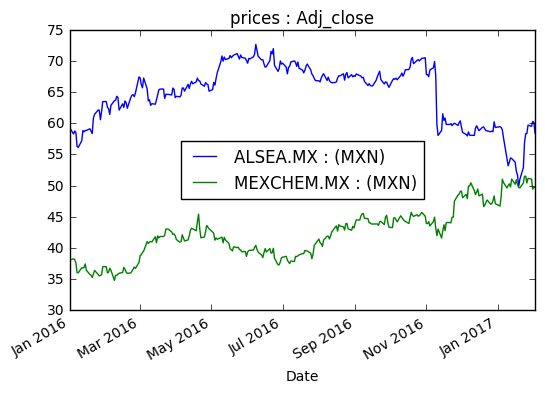

In [6]:
stocks['ALSEA'].plot([stocks['MEXCHEM']])


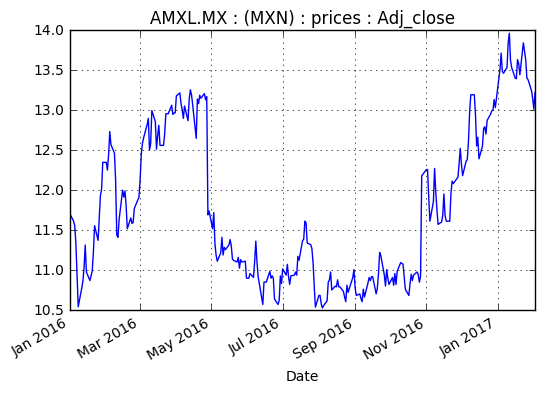

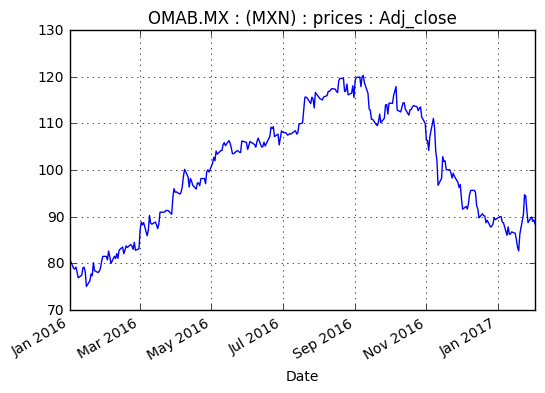

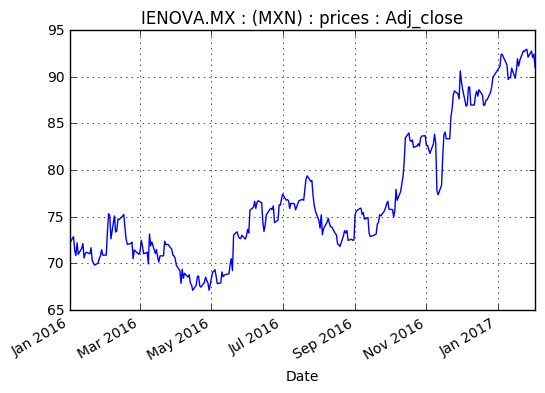

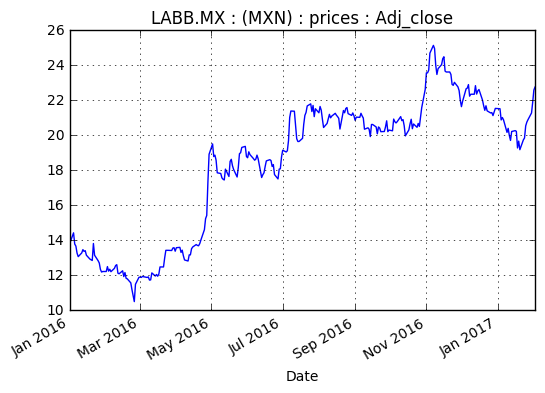

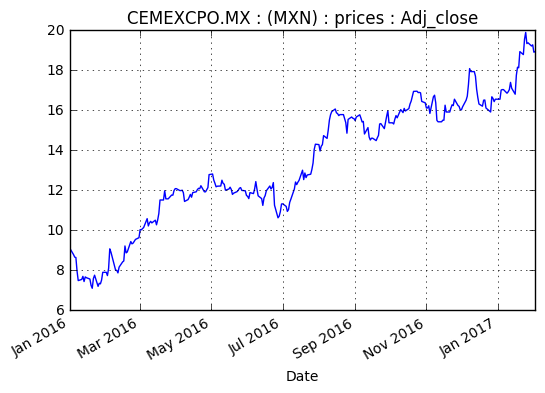

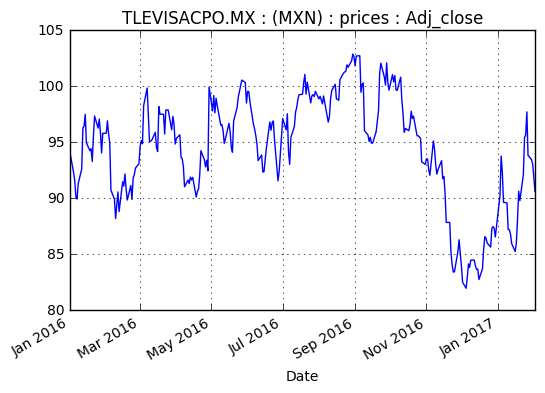

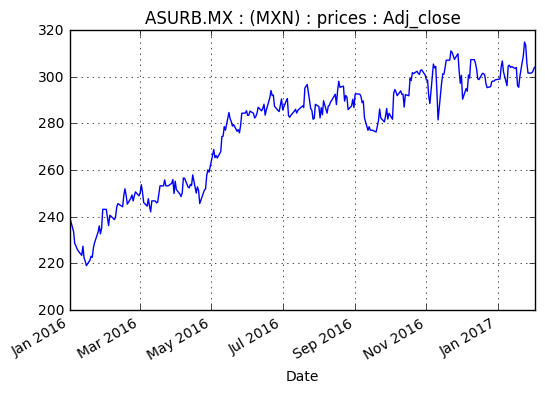

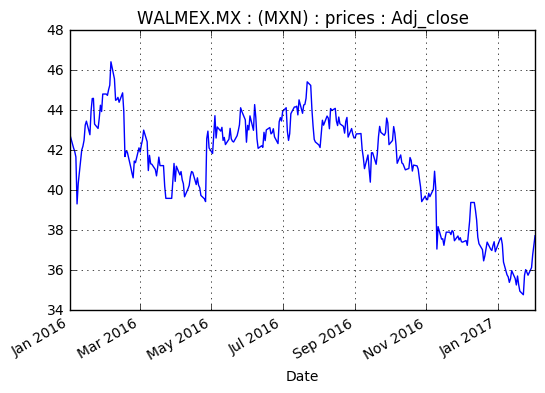

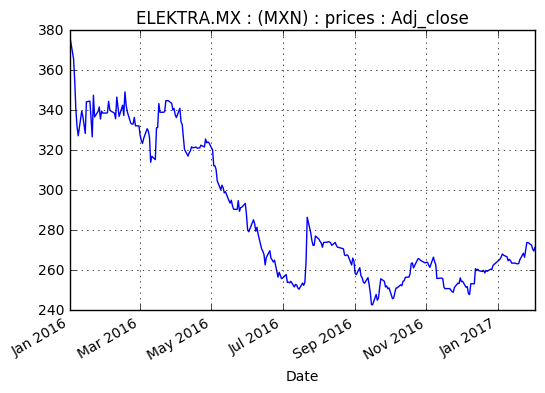

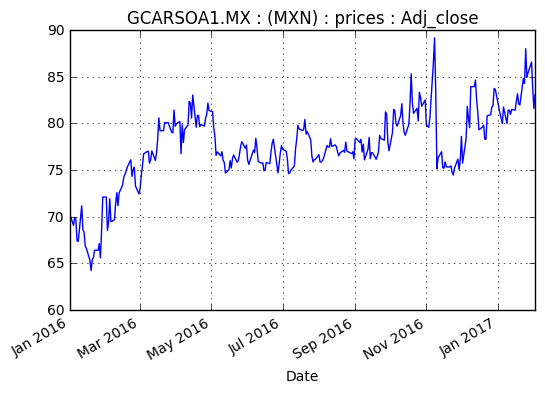

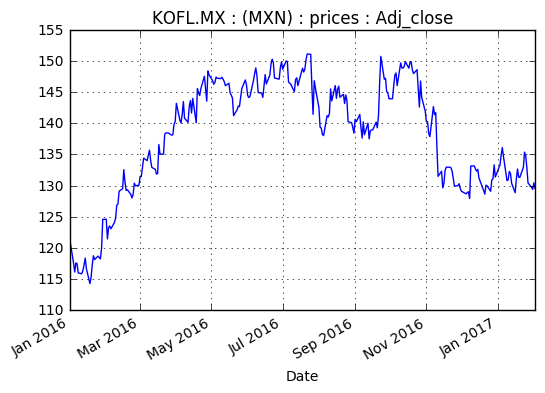

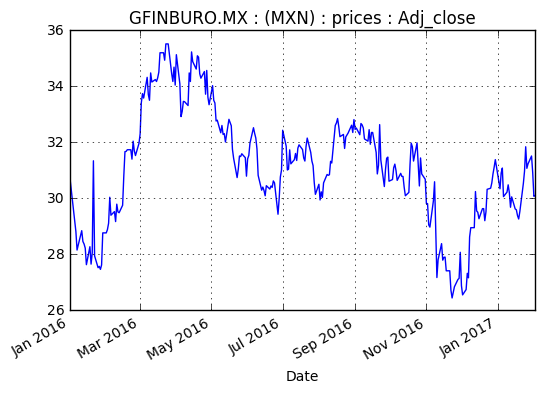

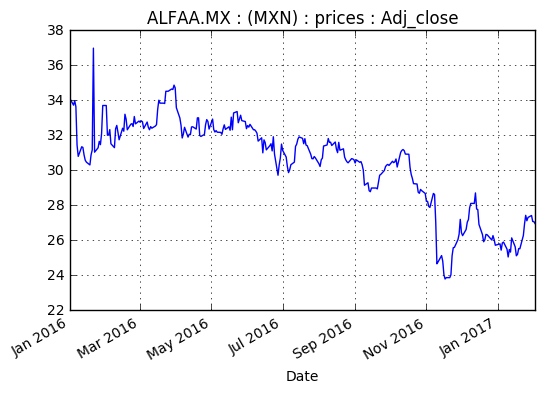

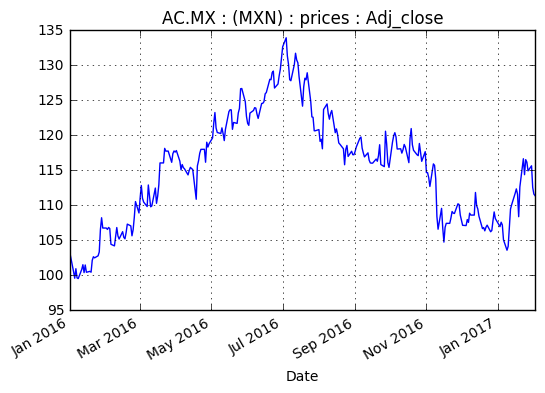

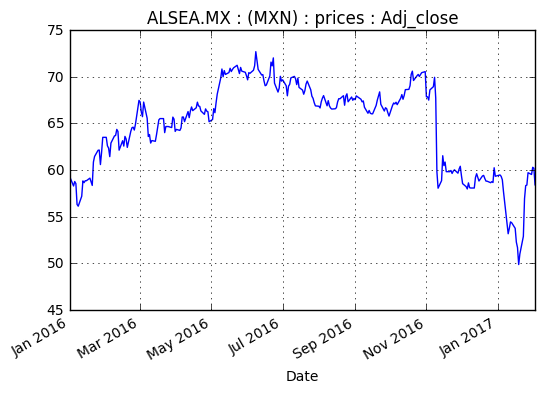

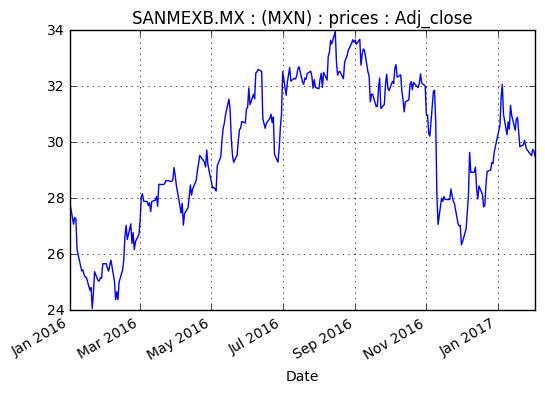

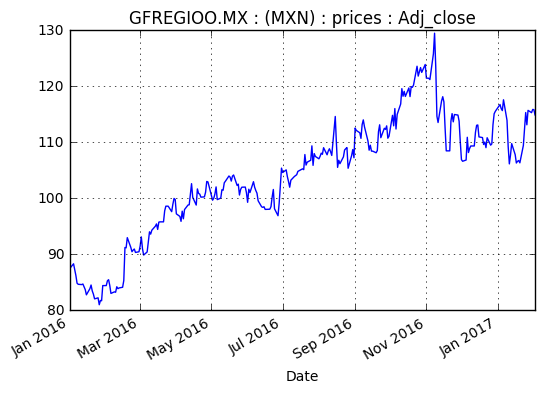

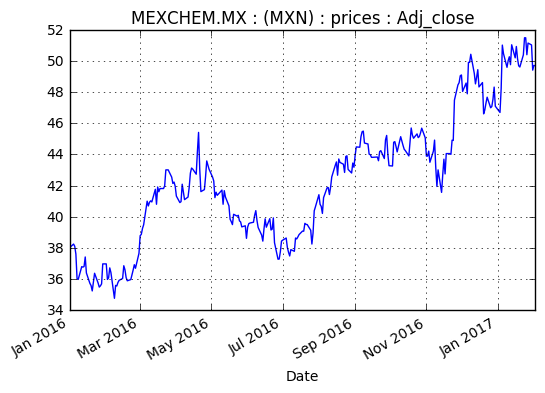

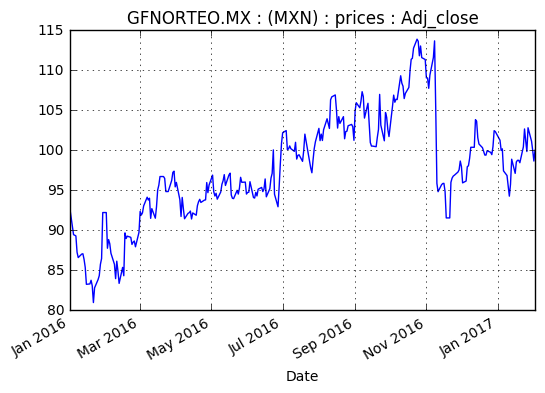

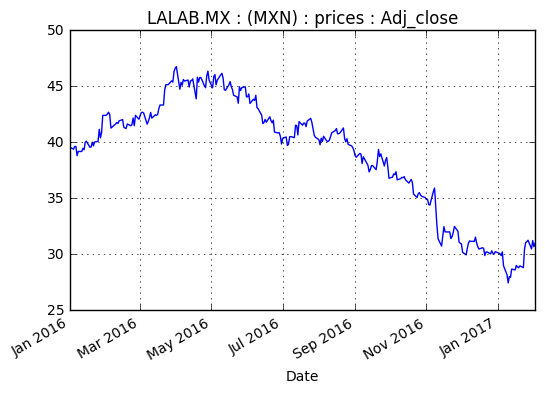

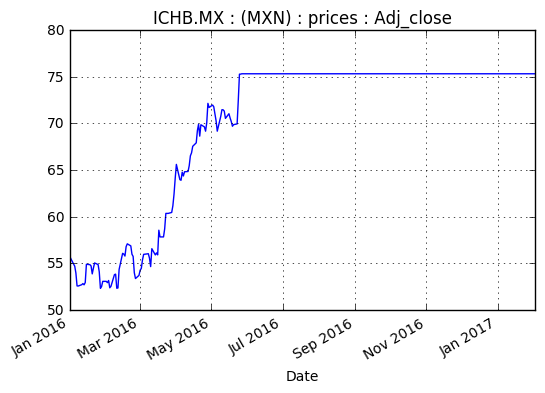

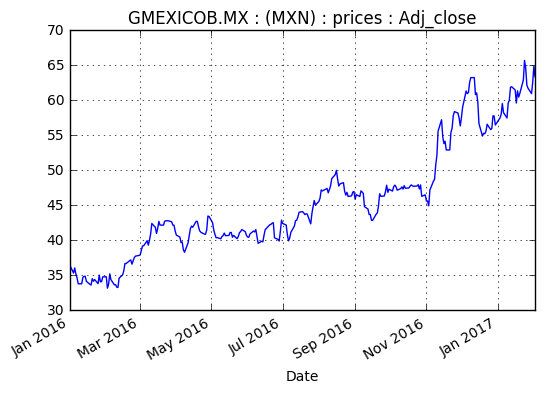

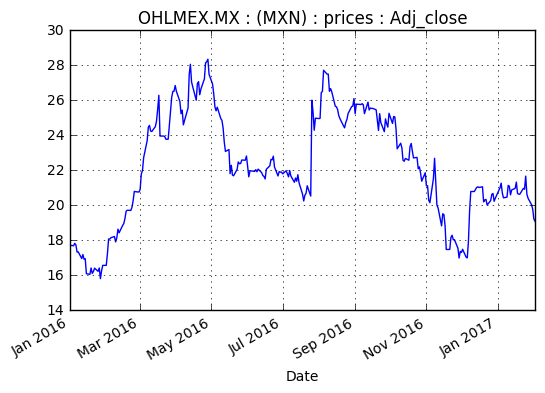

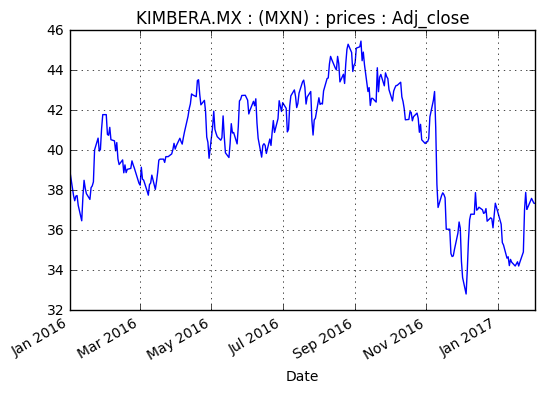

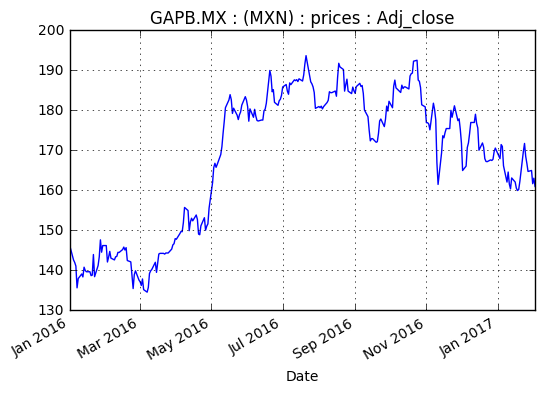

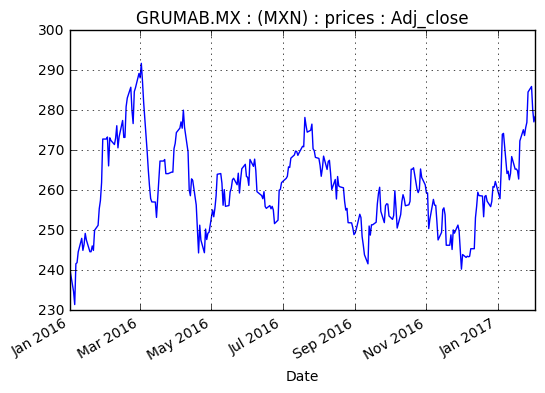

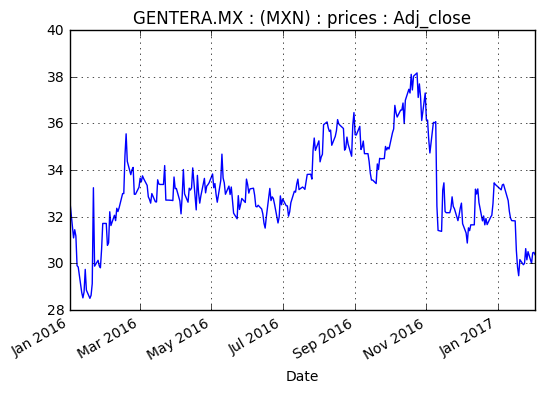

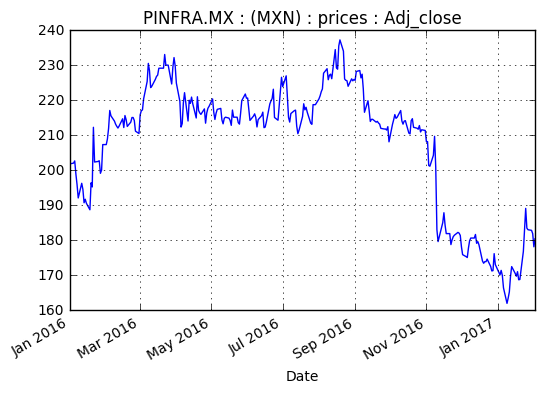

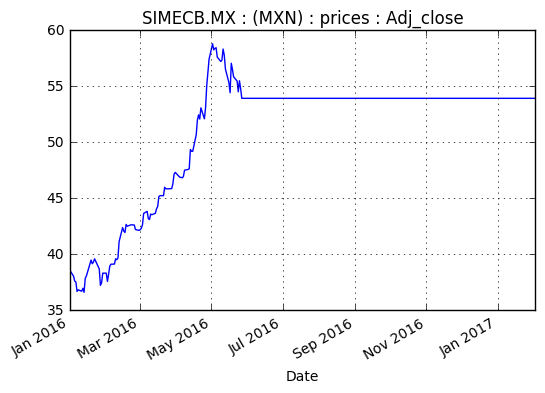

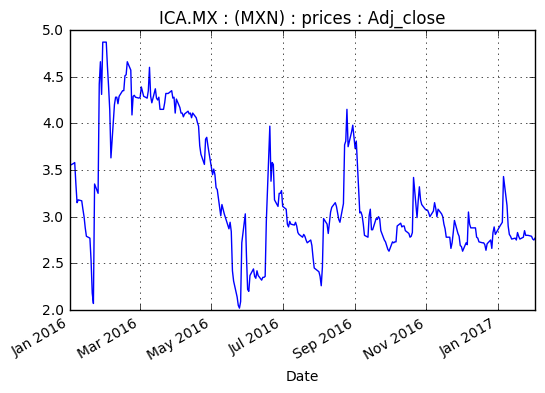

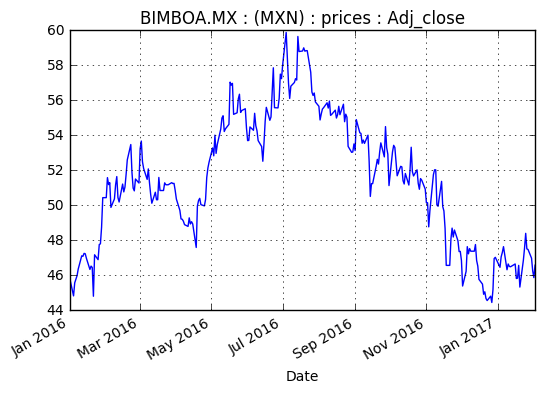

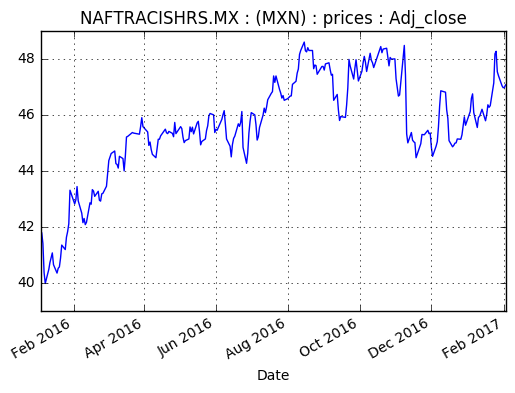

In [7]:
def temp_func(x):
    x.plot();plt.grid()
    plt.show()
    
temp = [temp_func(k) for k in stocks.values()]

# Download exchange rate 

In [8]:
USDMXN = Currency(base='USD',units='MXN',t0='2016/01/01',tf='2017/02/02')
USDMXN.fill()

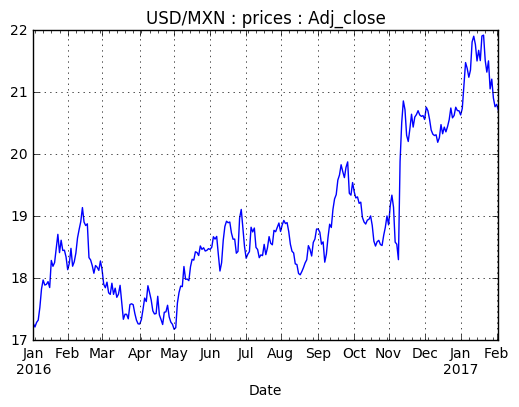

In [9]:
USDMXN.plot();plt.grid()

## Identify Correlation with Exchange Rate

In [10]:
def getReturns(x):
    return x.returns.Adj_close.values

def equalReturnsLength(x,y):
    _x = getReturns(x).shape
    _y = getReturns(y).shape
    return _x[0] == _y[0] 

def getCov(x,y):
    return np.cov(np.matrix([getReturns(x),getReturns(y)]))

def getCorr(x,y):
    cov_mat = getCov(x,y)
    cov = cov_mat[0,1]
    return cov / (np.std(getReturns(x))*np.std(getReturns(y)))

def matchObj(x,y):
    import copy
    df = pd.concat([x.prices.Adj_close, y.prices.Adj_close],1).dropna().copy()
    _x,_y = df.iloc[:,0],df.iloc[:,1]
    temp_x = copy.deepcopy(x)
    temp_x.prices = pd.DataFrame({'Adj_close':_x.values})
    temp_x.calc_returns()
    
    temp_y = copy.deepcopy(y)
    temp_y.prices = pd.DataFrame({'Adj_close':_y.values})
    temp_y.calc_returns()
    return temp_x, temp_y
    
    
def scatterPlotReturns(x,y):
    _x,_y = matchObj(x,y)
    x_d = pd.DataFrame({'x1':getReturns(_x)})
    y_d = pd.DataFrame({'y':getReturns(_y)})
    neuron = adaline(x_data = x_d, y_data = y_d) 
    neuron.train()
    neuron.evaluate()

    plt.plot(neuron.x_data, neuron.y_data,'b.',
             neuron.x_data, neuron.y_estimate, 'r-')
    plt.title('Scatter Plot of Returns and Linear Estimation \nCorrelation: {}'.format(getCorr(_x,_y)))
    plt.xlabel('Returns of : {}'.format(x.name()))
    plt.ylabel('Returns of : {}'.format(y.name()))
    plt.grid()
    plt.show()

In [11]:
positive_corr = []
negative_corr = []
best_positive_corr = -float('inf')
best_negative_corr = float('inf')
evaluated_stocks = 0

for k in stocks:
    
    temp_x, temp_y = matchObj(USDMXN,stocks[k])
    
    temp = getCorr(temp_x,temp_y)
    
    # save positive corr
    if temp > 0.5:
        positive_corr.append(k)
        
    if temp < -0.5:
        negative_corr.append(k)
        
    if temp > best_positive_corr:
        best_positive_corr = temp
        pos = k
        
    if temp < best_negative_corr:
        best_negative_corr = temp
        neg = k



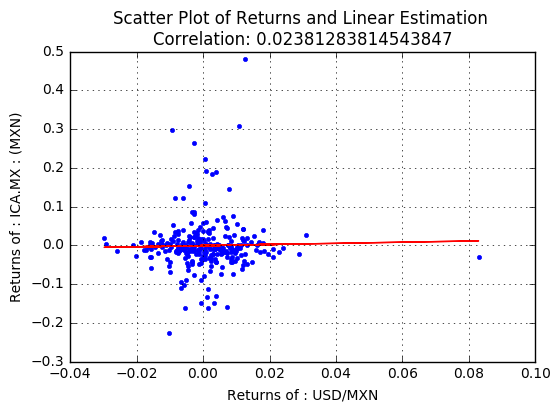

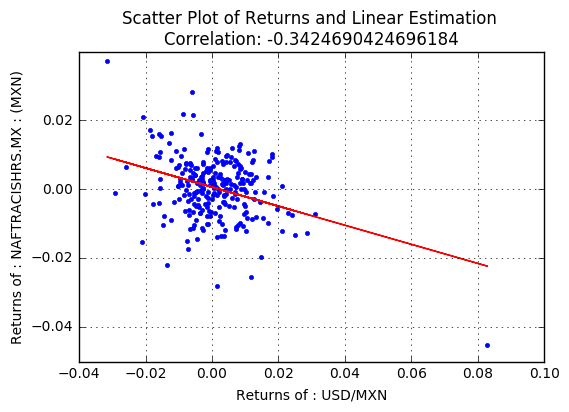

In [12]:
scatterPlotReturns(USDMXN,stocks[pos])
scatterPlotReturns(USDMXN,stocks[neg])


## Stationary Tests - ADF

In [13]:
found = []

for k in stocks:
    print('Evalualting: {}'.format(k))
    temp = (lambda x: adf(x.prices.Adj_close,0,1))(stocks[k])
    print('\n')
    if temp == 1:
        found.append(k)


Evalualting: AMX.L

Augmented Dickey-Fuller Test for unit root variable.

	 >> ADF t-statistic: -1.7072
	 >> Number of lags: 1
	 >> AR(1) Estimates: [lambda = -0.0229, lambda + 1 = 0.9771]
	 >> Half-life (days): [[ 32.86219664]]

Critical Values:

	 >> 1% Critic Value: -3.4404
	 >> 5% Critic Value: -2.8697
	 >> 10% Critic Value: -2.5829

Conclusion (90% of confidence): 

	 >> The price series is not mean regresive.


Evalualting: OMA.B

Augmented Dickey-Fuller Test for unit root variable.

	 >> ADF t-statistic: -1.5698
	 >> Number of lags: 1
	 >> AR(1) Estimates: [lambda = -0.0117, lambda + 1 = 0.9883]
	 >> Half-life (days): [[ 60.14698198]]

Critical Values:

	 >> 1% Critic Value: -3.4404
	 >> 5% Critic Value: -2.8697
	 >> 10% Critic Value: -2.5829

Conclusion (90% of confidence): 

	 >> The price series is not mean regresive.


Evalualting: IENOVA

Augmented Dickey-Fuller Test for unit root variable.

	 >> ADF t-statistic: -0.4764
	 >> Number of lags: 1
	 >> AR(1) Estimates: [lambda 

/home/rhdzmota/anaconda3/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:318: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = N.ndarray.__getitem__(self, index)



Augmented Dickey-Fuller Test for unit root variable.

	 >> ADF t-statistic: -1.8207
	 >> Number of lags: 1
	 >> AR(1) Estimates: [lambda = -0.0173, lambda + 1 = 0.9827]
	 >> Half-life (days): [[ 38.32655989]]

Critical Values:

	 >> 1% Critic Value: -3.4404
	 >> 5% Critic Value: -2.8697
	 >> 10% Critic Value: -2.5829

Conclusion (90% of confidence): 

	 >> The price series is not mean regresive.


Evalualting: WALMEX

Augmented Dickey-Fuller Test for unit root variable.

	 >> ADF t-statistic: -1.8011
	 >> Number of lags: 1
	 >> AR(1) Estimates: [lambda = -0.0264, lambda + 1 = 0.9736]
	 >> Half-life (days): [[ 26.12974967]]

Critical Values:

	 >> 1% Critic Value: -3.4404
	 >> 5% Critic Value: -2.8697
	 >> 10% Critic Value: -2.5829

Conclusion (90% of confidence): 

	 >> The price series is not mean regresive.


Evalualting: ELEKTRA

Augmented Dickey-Fuller Test for unit root variable.

	 >> ADF t-statistic: -2.0235
	 >> Number of lags: 1
	 >> AR(1) Estimates: [lambda = -0.0150, lambda

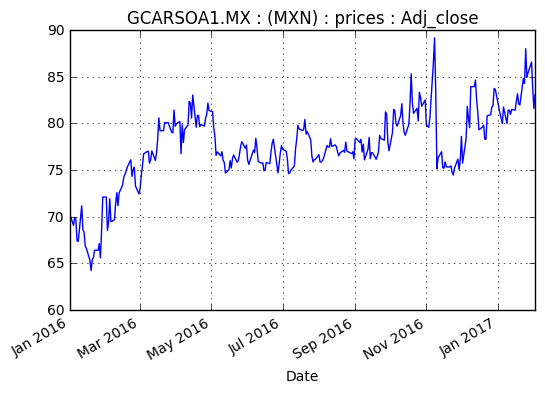

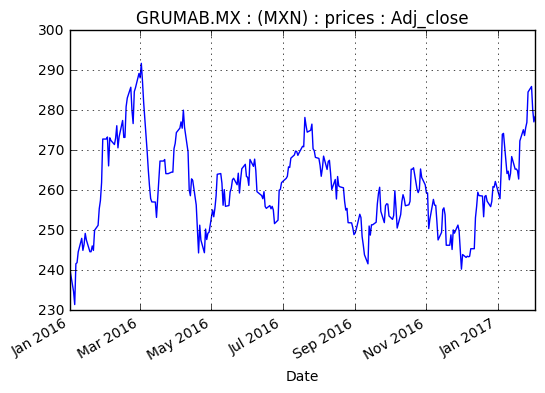

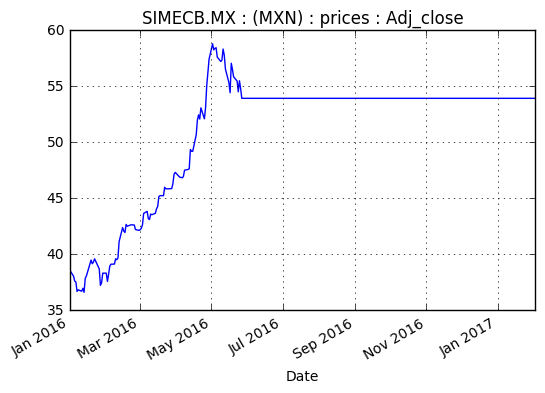

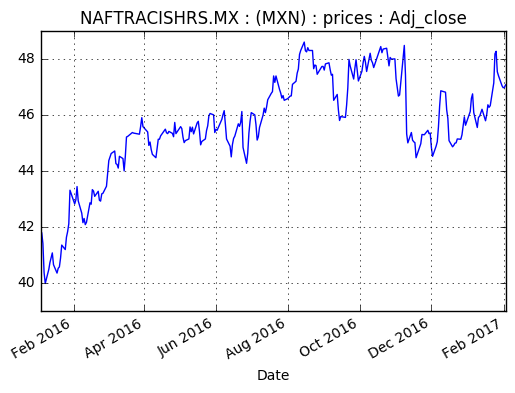

In [14]:
for k in found:
    stocks[k].plot();plt.grid();plt.show()

## Perform operations 

In [ ]:
ts.performOperation('compra','ALSEA','60','100')

In [ ]:
ts.getExchangeRates()

## Close 

In [ ]:
ts.close()